In [6]:
import numpy as np
import gym
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque, namedtuple
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
cpu_count = os.cpu_count()
print(f"CPU count: {cpu_count}")
torch.set_num_threads(cpu_count)
print(f"PyTorch threads: {torch.get_num_threads()}")
print(f"PyTorch device: {device}")



CPU count: 8
PyTorch threads: 8
PyTorch device: cpu


In [9]:

# Environmental global variables:
SEED = 42

# Making the environment:
env = gym.make('LunarLander-v2')
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
env.action_space.seed(SEED)  # Ensures deterministic action sampling

# Hyperparameters:
learning_rate = 0.005
gamma = 0.99
num_iterations = 1000
number_episodes_per_update = 100
TAU = 0.00




# Defining the neural network:
space_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(f"Space_dim: {space_dim}, Action_dim: {action_dim}")



class Model(nn.Module):
    def __init__(self, state_size, action_size):
        super(Model, self).__init__()
        self.seed = torch.manual_seed(SEED)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        action_probabilities = F.softmax(self.fc3(state), dim=1)
        return action_probabilities
    



# Defining the DQN Agent:
class PGAgent:
    def __init__(self, state_size, action_size):
        self.seed = random.seed(SEED)
        self.state_size = state_size
        self.action_size = action_size

        self.local_nn = Model(state_size=state_size, action_size=action_size).to(device)


        self.optimizer = optim.Adam(self.local_nn.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()

        #self.memory = ReplayBuffer(replay_memory_capacity, action_size)
        self.t_step = 0
        self.tau = TAU
        self.gamma = gamma


    def play_multiple_episodes(self, env, n_episodes, n_max_steps, model, loss_fn, optimizer, discount_factor):
        all_rewards = []
        all_grads = []
        for episode in range(n_episodes):
            current_rewards = []
            current_grads = []
            obs = env.reset()
            done = False
            while not done:
                obs, reward, done, grads = self.play_one_step(env=env, state=obs)
                current_grads.append(grads)
                current_rewards.append(reward)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_grads.append(current_grads)
        return all_rewards, all_grads


    '''
    def compute_loss_and_grads(self, state):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)  # Convert to tensor, add batch dimension
        probas = self.local_nn(state_tensor) #Get raw probabilities
        action = torch.multinomial(probas, num_samples=1).item() #Sample action
        loss = self.loss_fn(probas, torch.tensor([action])) #Calculate loss
        self.local_nn.zero_grad() #Zero gradients
        loss.backward()
        grads = [param.grad.data for param in self.local_nn.parameters()] #Get gradients 
        return loss,grads, action
    '''
    def compute_loss_and_grads(self, state):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)  # Convert state to tensor

        probas = self.local_nn(state_tensor)  # Get raw probabilities
        log_probas = torch.log(probas + 1e-7)  # Convert to log probabilities (numerical stability)
        
        action = torch.multinomial(torch.exp(log_probas), num_samples=1).item()  # Sample from log probas
        
        loss = self.loss_fn(log_probas, torch.tensor([action], dtype=torch.long))  # Compute loss
        
        self.local_nn.zero_grad()  # Zero gradients
        loss.backward()
        
        grads = [param.grad for param in self.local_nn.parameters()]  # Get gradients
        
        return loss, grads, action


    def take_action_and_step(self, env, action):
        obs, reward, done, info = env.step(action)
        return obs, reward, done, info

    def play_one_step(self, env, state):
        loss, grads, action = self.compute_loss_and_grads(state=state)

        state, reward, done, info = self.take_action_and_step(env=env, action=action)

        return state, reward, done, grads

    def discount_rewards(self, rewards):
        discounted = np.array(rewards, dtype=np.float64)
        for step in range(len(rewards) - 2, -1, -1):
            discounted[step] += discounted[step + 1] * self.gamma
        return discounted

    def discount_and_normalize_rewards(self, all_rewards):
        all_discounted_rewards = [self.discount_rewards(rewards=rewards) for rewards in all_rewards]
        flat_rewards = np.concatenate(all_discounted_rewards)
        reward_mean = flat_rewards.mean()
        reward_std = flat_rewards.std()
        if reward_std == 0:
            return [(discounted_rewards - reward_mean) for discounted_rewards in all_discounted_rewards]
        return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]



    # ====================== Gradient related functions ======================

    def compute_mean_grads(self, all_final_rewards, all_grads):
        all_mean_grads = []
        
        # Loop over each model's parameter
        for param_index, param in enumerate(self.local_nn.parameters()):
            grad_list = []

            # We need to iterate over the rewards and gradients for each episode and step
            for episode_index, final_rewards in enumerate(all_final_rewards):
                for step, final_reward in enumerate(final_rewards):
                    grad = all_grads[episode_index][step][param_index] #access gradient with param_index
                    grad_list.append(final_reward * grad)

            # Convert grad_list into a tensor and compute the mean gradient
            if len(grad_list) > 0:
                grad_tensor = torch.stack(grad_list)
                mean_grad = torch.mean(grad_tensor, dim=0)
                all_mean_grads.append(mean_grad)
            else:
                all_mean_grads.append(torch.zeros_like(param.data)) # Add zero tensor if no gradients exist.
        return all_mean_grads


    def apply_gradients(self, all_mean_grads):
        self.before_update__weights = self.local_nn.parameters()
        self.optimizer.zero_grad()  # Clear existing gradients
        for param, mean_grad in zip(self.local_nn.parameters(), all_mean_grads):
            if param.grad is None:
                param.grad = torch.zeros_like(param.data) #initialize param.grad if it is None
            param.grad.data = mean_grad.data # Assign the mean gradients
        self.optimizer.step()

    def general_gradient(self, all_mean_grads): #tau defaults to 1.0 (hard update)
        self.apply_gradients(all_mean_grads=all_mean_grads)
        self.soft_update()

   
    
    def soft_update(self):
       
        with torch.no_grad():
            for before_update_weights, after_update_weights in zip(self.before_update__weights, self.local_nn.parameters()):
                after_update_weights.data.copy_((1-self.tau)*before_update_weights.data + self.tau * (after_update_weights.data))







def plot_training(mean_rewards_list, total_rewards_list):
    # Use Seaborn to plot rewards per episode
    sns.set_style("darkgrid")  # Set a nice style
    plt.figure(figsize=(10, 5))  # Set figure size

    sns.lineplot(x=range(len(total_rewards_list)), y=total_rewards_list, label="Total Reward per Episode")
    sns.lineplot(x=range(len(mean_rewards_list)), y=mean_rewards_list, label="Mean Reward (50 episodes)")

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress: Rewards per Episode")
    plt.legend()
    plt.show()

def print_training_parameters(learning_rate, gamma, num_iterations, number_episodes_per_update, TAU, SEED):
    print(f"\n")
    print(f"=====================================================================================================")
    print(f"==================================== Training Parameters ===========================================")
    print(f"=====================================================================================================")
    print(f"Number of iterations: {num_iterations}")
    print(f"Number of episodes per update: {number_episodes_per_update}")
    print(f"TAU: {TAU}")
    print(f"Learning rate: {learning_rate}")
    print(f"Gamma: {gamma}")
    print(f"Seed: {SEED}")
    print(f"=====================================================================================================")
    print(f"\n")

def update_number_episodes_per_update(number_episodes_per_update,i_iter):
    if i_iter >= 200:
        if i_iter % 200 == 0:
            number_episodes_per_update = number_episodes_per_update + 5

    return number_episodes_per_update

#Making the RL_model
def train_Agent():
    global number_episodes_per_update  # Declare as global to modify it within this function

    
    print_training_parameters(learning_rate=learning_rate, gamma=gamma, num_iterations=num_iterations, number_episodes_per_update=number_episodes_per_update, TAU=TAU, SEED=SEED)
    mean_rewards_list = []
    total_rewards_list = []
    best_mean_reward = -np.inf
    
    #Make the agent
    agent = PGAgent(state_size=space_dim, action_size=action_dim)

    for i_iter in range(num_iterations):
        
        # Play multiple episodes and get rewards
        all_rewards, all_grads = agent.play_multiple_episodes(env=env, n_episodes=number_episodes_per_update, n_max_steps=1000, model=agent.local_nn, loss_fn=agent.loss_fn, optimizer=agent.optimizer, discount_factor=gamma)
        total_rewards = sum(map(sum, all_rewards))
      
        total_rewards_list.append(total_rewards/number_episodes_per_update)
        mean_rewards = np.mean(total_rewards_list[-50:] if len(total_rewards_list) >= 50 else total_rewards_list)
        mean_rewards_list.append(mean_rewards)

        if i_iter % 30==0:
            print(f" Episode: {i_iter}, Total Reward per episode: {total_rewards_list[-1]}, Mean Reward per iter: {mean_rewards}, Number of episodes per update: {number_episodes_per_update}")

        
        all_final_rewards = agent.discount_and_normalize_rewards(all_rewards=all_rewards)
        
        all_mean_grads = agent.compute_mean_grads(all_final_rewards=all_final_rewards, all_grads=all_grads)
        agent.general_gradient(all_mean_grads=all_mean_grads)

        if mean_rewards > best_mean_reward:
            best_mean_reward = mean_rewards
            torch.save(agent.local_nn.state_dict(), 'local_nn_parameters.pth')
        
        #number_episodes_per_update = update_number_episodes_per_update(i_iter=i_iter, number_episodes_per_update=number_episodes_per_update)

    plot_training(mean_rewards_list, total_rewards_list)
  

Space_dim: 8, Action_dim: 4




==================================== Training Parameters ===========================================
Number of iterations: 1000
Number of episodes per update: 100
TAU: 0.0
Learning rate: 0.005
Gamma: 0.99
Seed: 42


 Episode: 0, Total Reward per episode: -179.0989549707768, Mean Reward per iter: -179.0989549707768, Number of episodes per update: 100
 Episode: 30, Total Reward per episode: -53.556594338809134, Mean Reward per iter: -120.87274957358896, Number of episodes per update: 100
 Episode: 60, Total Reward per episode: 21.73987929546987, Mean Reward per iter: -56.632354646807755, Number of episodes per update: 100
 Episode: 90, Total Reward per episode: 104.68600051334624, Mean Reward per iter: 29.68956817686195, Number of episodes per update: 100
 Episode: 120, Total Reward per episode: 138.4324841355001, Mean Reward per iter: 104.14637777527805, Number of episodes per update: 100
 Episode: 150, Total Reward per episode: 124.26460055045489, Mean Reward per iter: 137.7633330847

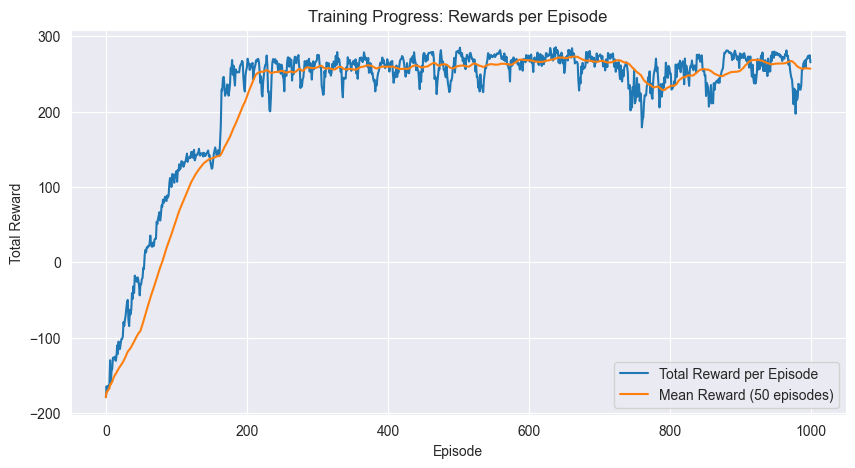

In [ ]:
train_Agent() 